In [14]:
%pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

# Increase plot size
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('whitegrid')

BASE_DIR = Path('C:/Users/Mediatek/Desktop/ML-project/ML')


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 799.2 kB/s eta 0:01:30
    --------------------------------------- 1.0/72.0 MB 1.3 MB/s eta 0:00:55
    --------------------------------------- 1.6/72.0 MB 1.6 MB/s eta 0:00:45
   - -------------------------------------- 1.8/72.0 MB 1.7 MB/s eta 0:00:43
   - -------------------------------------- 2.6/72.0 MB 1.9 MB/s eta 0:00:38
   - -------------------------------------- 3.1/72.0 MB 1.9 MB/s eta 0:00:36
   - -------------------------------------- 3.4/72.0 MB 1.9 MB/s eta 0:00:37
   -- ------------------------------------- 3.7/72.0 MB 1.8 MB/s eta 0:00:38
   -- ------------------------------------- 4.2/72.0 MB 1.9 MB/s eta 0:00:36
   -- ------------------------------------- 4.7/72.0 MB 2.0 MB/s eta 0:00:34
   -- ------------

## 1. Load and Explore Datasets

In [6]:
# Load rent data
df_rent = pd.read_csv(BASE_DIR / 'data/processed/rent_clustered.csv')
print("="*80)
print("RENT DATASET")
print("="*80)
print(f"Shape: {df_rent.shape}")
print(f"\nColumns: {df_rent.columns.tolist()}")
print(f"\nData types:\n{df_rent.dtypes}")
print(f"\nMissing values:\n{df_rent.isnull().sum()}")
print(f"\nBasic statistics:\n{df_rent.describe()}")

# Load sale data
df_sale = pd.read_csv(BASE_DIR / 'data/processed/sale_clustered.csv')
print("\n" + "="*80)
print("SALE DATASET")
print("="*80)
print(f"Shape: {df_sale.shape}")
print(f"\nBasic statistics:\n{df_sale.describe()}")

RENT DATASET
Shape: (5570, 10)

Columns: ['city', 'region', 'price', 'price_normalized', 'surface', 'rooms', 'bathrooms', 'property_type', 'property_type_cluster', 'price_segment']

Data types:
city                      object
region                    object
price                    float64
price_normalized         float64
surface                  float64
rooms                      int64
bathrooms                  int64
property_type             object
property_type_cluster      int64
price_segment             object
dtype: object

Missing values:
city                     0
region                   0
price                    0
price_normalized         0
surface                  0
rooms                    0
bathrooms                0
property_type            0
property_type_cluster    0
price_segment            0
dtype: int64

Basic statistics:
              price  price_normalized      surface        rooms    bathrooms  \
count   5570.000000      5.570000e+03  5570.000000  5570.000000

## 2. Calculate Correlation Matrix (Numeric Features Only)

In [7]:
# RENT correlations
print("="*80)
print("RENT - Numeric Feature Correlations")
print("="*80)

numeric_cols_rent = df_rent.select_dtypes(include=[np.number]).columns
corr_rent = df_rent[numeric_cols_rent].corr()

# Correlations with price
price_corr_rent = corr_rent['price'].sort_values(ascending=False)
print("\nCorrelation with PRICE (Rent):")
print(price_corr_rent)

# SALE correlations
print("\n" + "="*80)
print("SALE - Numeric Feature Correlations")
print("="*80)

numeric_cols_sale = df_sale.select_dtypes(include=[np.number]).columns
corr_sale = df_sale[numeric_cols_sale].corr()

price_corr_sale = corr_sale['price'].sort_values(ascending=False)
print("\nCorrelation with PRICE (Sale):")
print(price_corr_sale)

RENT - Numeric Feature Correlations

Correlation with PRICE (Rent):
price                    1.000000
price_normalized         1.000000
rooms                    0.534513
bathrooms                0.448928
surface                  0.424585
property_type_cluster    0.397951
Name: price, dtype: float64

SALE - Numeric Feature Correlations

Correlation with PRICE (Sale):
price                    1.000000
price_normalized         1.000000
bathrooms                0.584060
surface                  0.571502
rooms                    0.493456
property_type_cluster    0.002436
Name: price, dtype: float64


## 3. Visualize Correlation Heatmaps

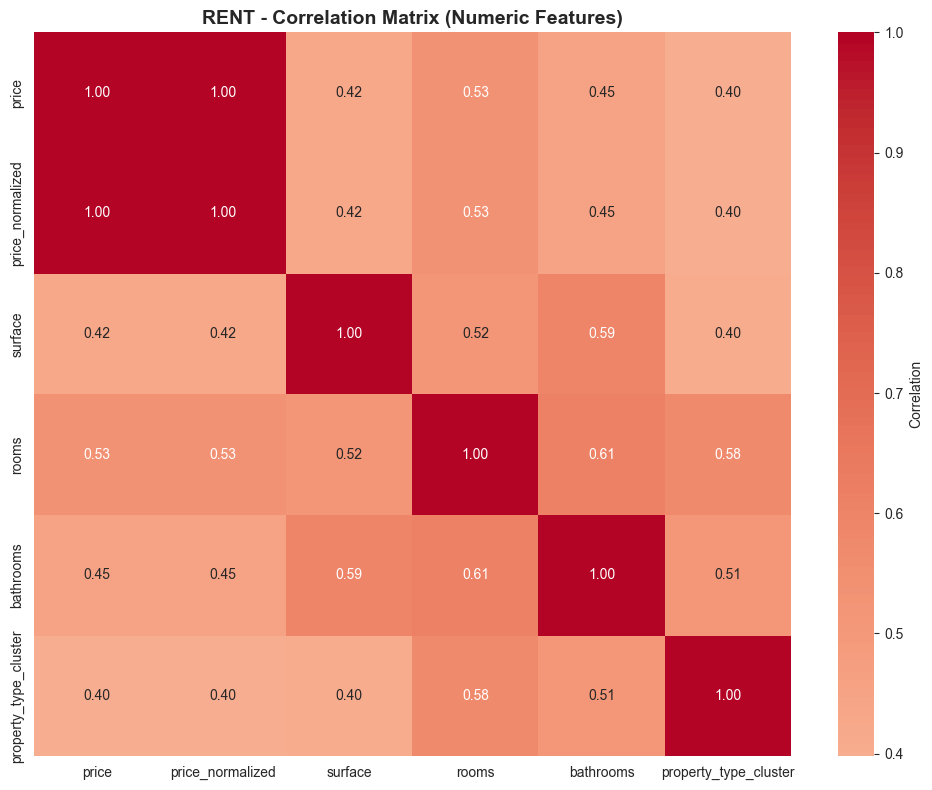

Heatmap created for RENT dataset


In [8]:
# RENT heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_rent, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('RENT - Correlation Matrix (Numeric Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Heatmap created for RENT dataset")

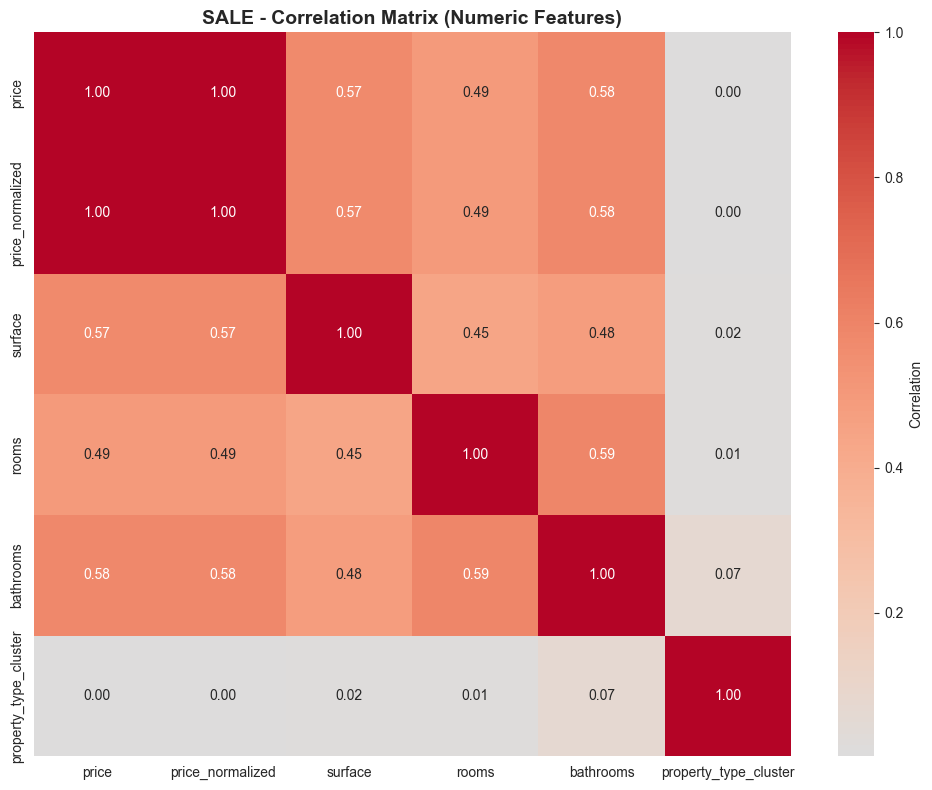

Heatmap created for SALE dataset


In [9]:
# SALE heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_sale, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('SALE - Correlation Matrix (Numeric Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Heatmap created for SALE dataset")

## 4. Analyze Feature Distributions

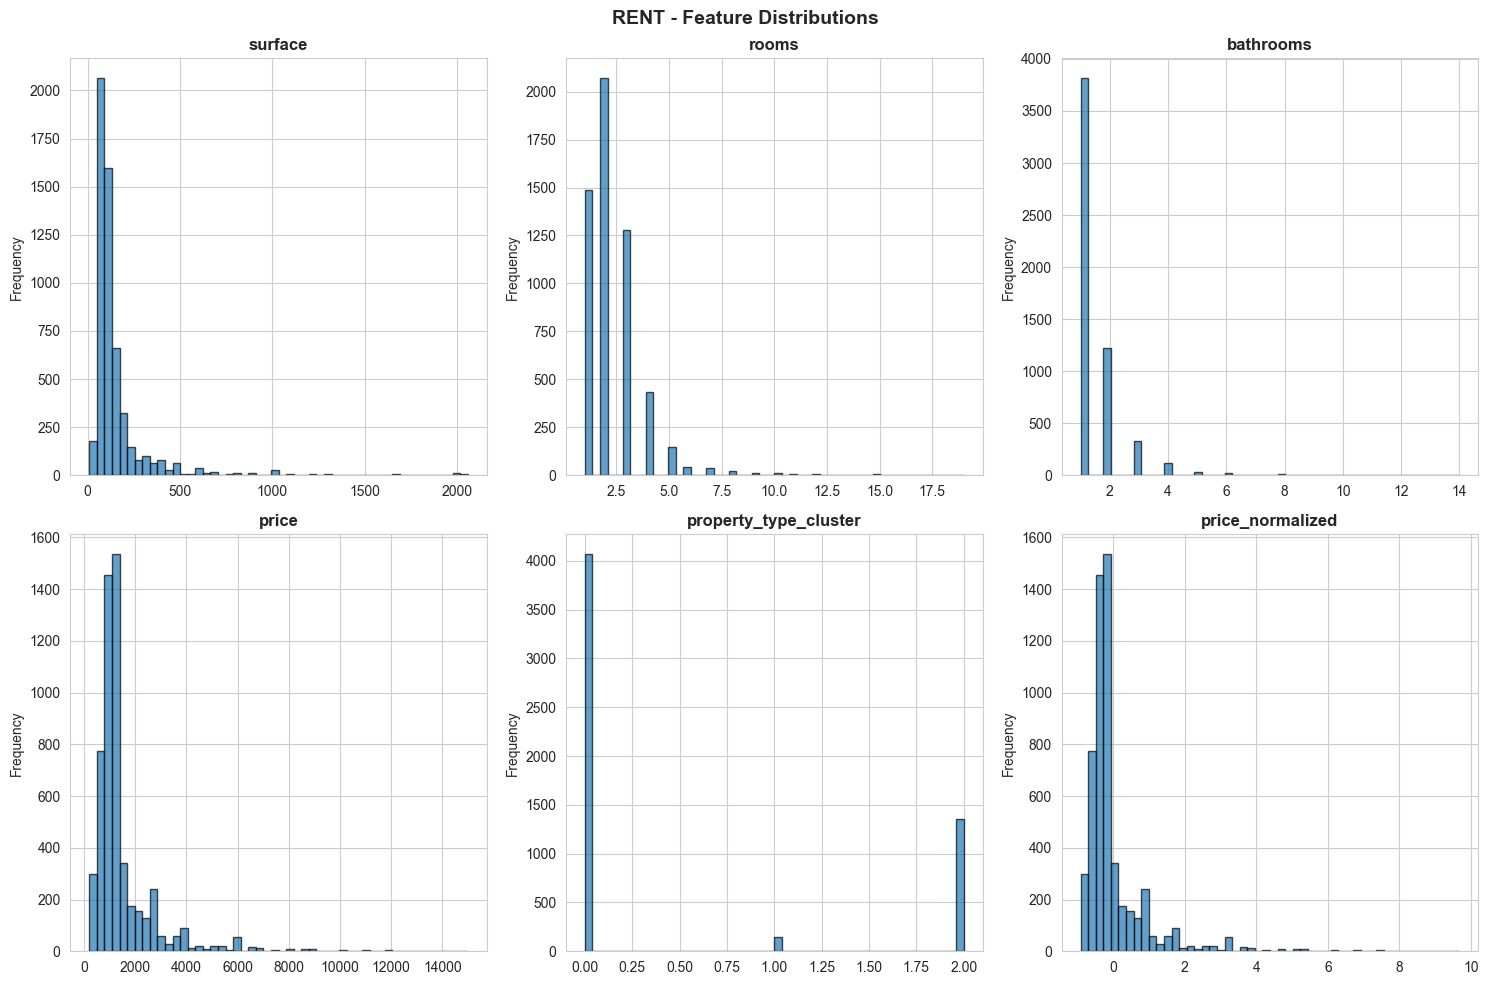


RENT - Skewness and Kurtosis:
surface              - Skewness:    5.59, Kurtosis:   41.55
rooms                - Skewness:    3.08, Kurtosis:   18.98
bathrooms            - Skewness:    4.98, Kurtosis:   39.83
price                - Skewness:    3.88, Kurtosis:   20.83
property_type_cluster - Skewness:    1.11, Kurtosis:   -0.71
price_normalized     - Skewness:    3.88, Kurtosis:   20.83


In [10]:
# RENT distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('RENT - Feature Distributions', fontsize=14, fontweight='bold')

numeric_features = ['surface', 'rooms', 'bathrooms', 'price', 'property_type_cluster', 'price_normalized']

for idx, col in enumerate(numeric_features):
    ax = axes[idx // 3, idx % 3]
    df_rent[col].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nRENT - Skewness and Kurtosis:")
for col in numeric_features:
    print(f"{col:20} - Skewness: {df_rent[col].skew():7.2f}, Kurtosis: {df_rent[col].kurtosis():7.2f}")

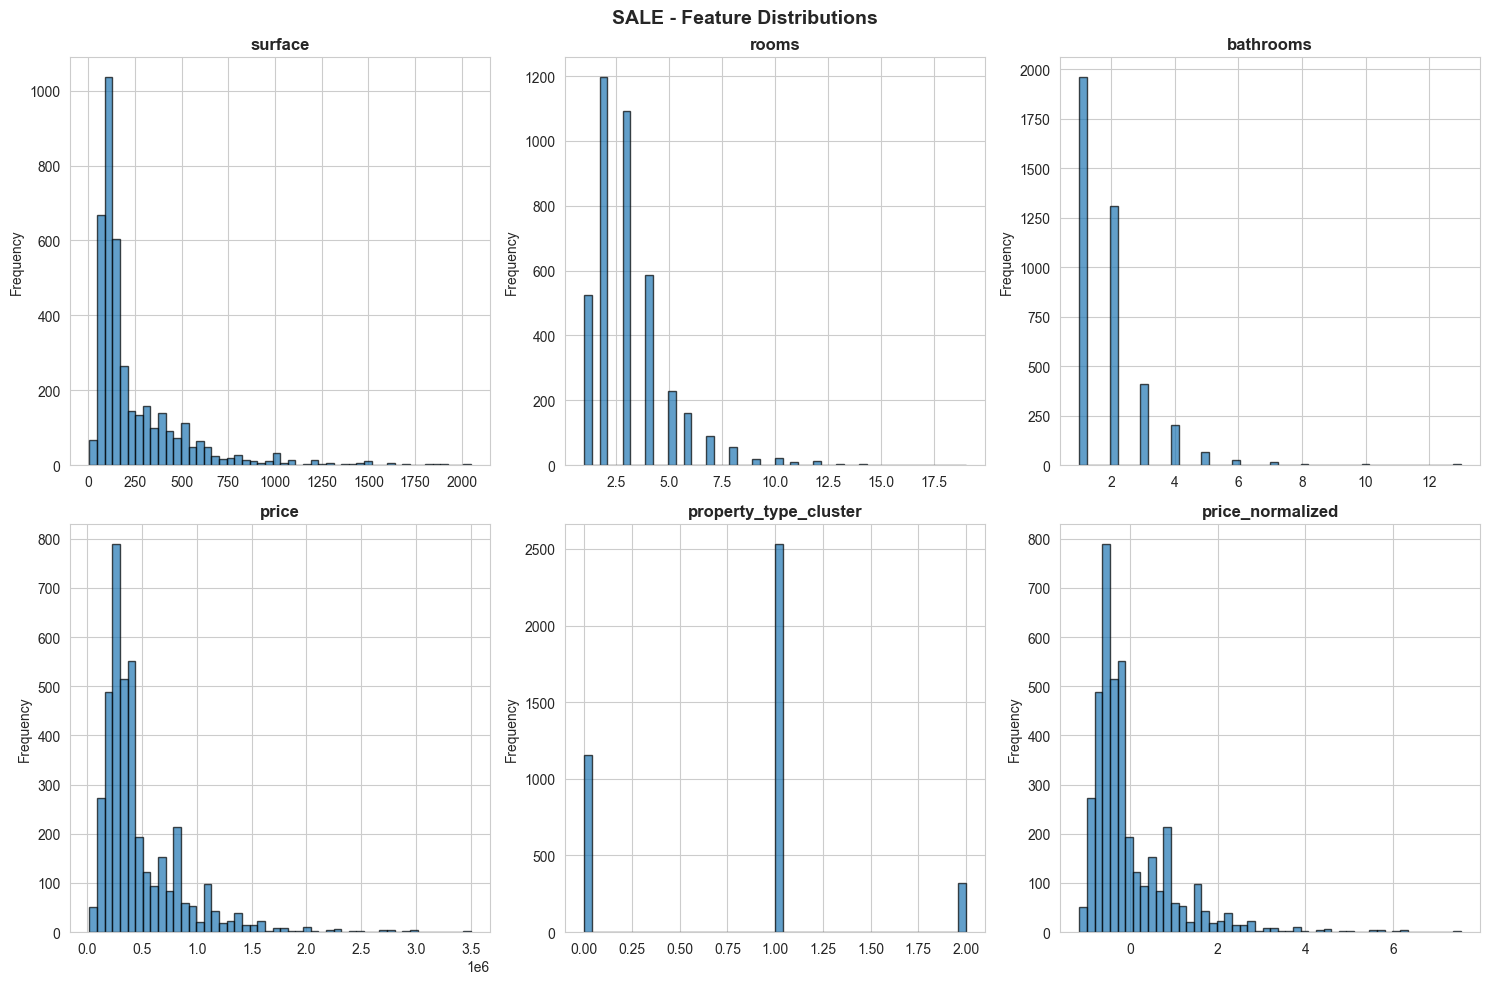


SALE - Skewness and Kurtosis:
surface              - Skewness:    2.71, Kurtosis:    9.48
rooms                - Skewness:    2.06, Kurtosis:    7.28
bathrooms            - Skewness:    2.95, Kurtosis:   15.85
price                - Skewness:    2.71, Kurtosis:   10.64
property_type_cluster - Skewness:    0.02, Kurtosis:   -0.30
price_normalized     - Skewness:    2.71, Kurtosis:   10.64


In [11]:
# SALE distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('SALE - Feature Distributions', fontsize=14, fontweight='bold')

for idx, col in enumerate(numeric_features):
    ax = axes[idx // 3, idx % 3]
    df_sale[col].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nSALE - Skewness and Kurtosis:")
for col in numeric_features:
    print(f"{col:20} - Skewness: {df_sale[col].skew():7.2f}, Kurtosis: {df_sale[col].kurtosis():7.2f}")

## 5. Analyze Categorical Features

In [12]:
print("="*80)
print("RENT - Categorical Features Analysis")
print("="*80)

print(f"\nUnique cities: {df_rent['city'].nunique()}")
print(f"City value counts (top 10):\n{df_rent['city'].value_counts().head(10)}")

print(f"\nUnique regions: {df_rent['region'].nunique()}")
print(f"Region value counts (top 10):\n{df_rent['region'].value_counts().head(10)}")

print(f"\nProperty types: {df_rent['property_type'].value_counts()}")

print(f"\nPrice segments: {df_rent['price_segment'].value_counts()}")

# Mean price by city
print(f"\nMean price by city (top 10):")
print(df_rent.groupby('city')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10))

# Mean price by price_segment
print(f"\nMean price by price_segment:")
print(df_rent.groupby('price_segment')['price'].agg(['mean', 'min', 'max', 'count']))

RENT - Categorical Features Analysis

Unique cities: 20
City value counts (top 10):
city
Tunis         2300
Ariana         958
Nabeul         666
Sousse         568
Ben Arous      355
Mahdia         174
Monastir       144
Sfax           124
Bizerte        123
La Manouba      58
Name: count, dtype: int64

Unique regions: 173
Region value counts (top 10):
region
L'Aouina               444
La Marsa               208
Jardins De Carthage    208
Centre Ville           200
Cité Ennasr 2          168
La Soukra              153
Mahdia                 151
Hammamet               148
Lac 2                  147
Ain Zaghouan Nord      144
Name: count, dtype: int64

Property types: property_type
Appartement    3631
Villa          1089
Maison          482
Studio          368
Name: count, dtype: int64

Price segments: price_segment
High      2806
Medium    2288
Low        476
Name: count, dtype: int64

Mean price by city (top 10):
                  mean  count
city                         
Tunis      1

## 6. Train Model and Extract Feature Importance

In [20]:
print("Preparing RENT data...")
X_train_rent, X_test_rent, y_train_rent, y_test_rent, feature_names_rent = prepare_data(df_rent, 'rent')

print("Preparing SALE data...")
X_train_sale, X_test_sale, y_train_sale, y_test_sale, feature_names_sale = prepare_data(df_sale, 'sale')

print(f"RENT - Train shape: {X_train_rent.shape}, Test shape: {X_test_rent.shape}")
print(f"SALE - Train shape: {X_train_sale.shape}, Test shape: {X_test_sale.shape}")

Preparing RENT data...
Preparing SALE data...
RENT - Train shape: (4318, 205), Test shape: (1080, 205)
SALE - Train shape: (3080, 209), Test shape: (770, 209)


In [19]:
from sklearn.metrics import r2_score

# Train RandomForest for RENT
print("\n" + "="*80)
print("RENT - Feature Importance Analysis")
print("="*80)

rf_rent = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_rent.fit(X_train_rent, y_train_rent)
rf_rent_r2 = r2_score(y_test_rent, rf_rent.predict(X_test_rent))
print(f"RandomForest Test R²: {rf_rent_r2:.4f}")

# Get top 15 important features
importance_rent = pd.DataFrame({
    'feature': feature_names_rent,
    'importance': rf_rent.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (RandomForest):")
print(importance_rent.head(15).to_string(index=False))

# Train XGBoost for RENT
xgb_rent = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.05, random_state=42)
xgb_rent.fit(X_train_rent, y_train_rent)
xgb_rent_r2 = r2_score(y_test_rent, xgb_rent.predict(X_test_rent))
print(f"\nXGBoost Test R²: {xgb_rent_r2:.4f}")

importance_xgb_rent = pd.DataFrame({
    'feature': feature_names_rent,
    'importance': xgb_rent.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (XGBoost):")
print(importance_xgb_rent.head(15).to_string(index=False))


RENT - Feature Importance Analysis
RandomForest Test R²: 0.6087

Top 15 Most Important Features (RandomForest):
                   feature  importance
                   surface    0.465262
        price_segment_High    0.112736
                 bathrooms    0.069258
                     rooms    0.063444
             avg_room_size    0.034160
             rooms_per_sqm    0.032088
        bathrooms_per_room    0.029180
                city_Tunis    0.027209
      property_type_Studio    0.013104
region_Jardins De Carthage    0.012314
              region_Lac 2    0.011984
              region_Lac 1    0.008864
       property_type_Villa    0.008467
      property_type_Maison    0.008354
 property_type_Appartement    0.006817

XGBoost Test R²: 0.6199

Top 15 Most Important Features (XGBoost):
                   feature  importance
        price_segment_High    0.157652
                   surface    0.060627
                city_Tunis    0.047476
  region_Ain Zaghouan Nord    0.037649


In [21]:
# Train RandomForest for SALE
print("\n" + "="*80)
print("SALE - Feature Importance Analysis")
print("="*80)

rf_sale = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_sale.fit(X_train_sale, y_train_sale)
rf_sale_r2 = r2_score(y_test_sale, rf_sale.predict(X_test_sale))
print(f"RandomForest Test R²: {rf_sale_r2:.4f}")

importance_sale = pd.DataFrame({
    'feature': feature_names_sale,
    'importance': rf_sale.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (RandomForest):")
print(importance_sale.head(15).to_string(index=False))

# Train XGBoost for SALE
xgb_sale = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.05, random_state=42)
xgb_sale.fit(X_train_sale, y_train_sale)
xgb_sale_r2 = r2_score(y_test_sale, xgb_sale.predict(X_test_sale))
print(f"\nXGBoost Test R²: {xgb_sale_r2:.4f}")

importance_xgb_sale = pd.DataFrame({
    'feature': feature_names_sale,
    'importance': xgb_sale.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (XGBoost):")
print(importance_xgb_sale.head(15).to_string(index=False))


SALE - Feature Importance Analysis
RandomForest Test R²: 0.6565

Top 15 Most Important Features (RandomForest):
             feature  importance
             surface    0.553314
           bathrooms    0.165797
       avg_room_size    0.026256
       rooms_per_sqm    0.022808
               rooms    0.021487
  bathrooms_per_room    0.017782
  price_segment_High    0.015541
property_type_Maison    0.013387
           city_Sfax    0.012373
   price_segment_Low    0.008565
     region_Kantaoui    0.005459
   region_Chotrana 2    0.005344
       region_Mornag    0.005269
     region_Hammamet    0.004976
      region_Sahloul    0.004852

XGBoost Test R²: 0.6671

Top 15 Most Important Features (XGBoost):
             feature  importance
           bathrooms    0.076193
             surface    0.063209
 region_Kalaa Kebira    0.025846
           city_Sfax    0.023903
     region_Hammamet    0.023186
  price_segment_High    0.019208
       region_Mornag    0.019194
   price_segment_Low    0.0

## 7. Visualize Feature Importance

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RandomForest
ax1 = axes[0]
top_n = 15
top_features_rf = importance_rent.head(top_n)
ax1.barh(range(len(top_features_rf)), top_features_rf['importance'].values)
ax1.set_yticks(range(len(top_features_rf)))
ax1.set_yticklabels(top_features_rf['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title(f'RENT - RandomForest Top {top_n} Features (R²={rf_rent_r2:.4f})', fontweight='bold')
ax1.invert_yaxis()

# XGBoost
ax2 = axes[1]
top_features_xgb = importance_xgb_rent.head(top_n)
ax2.barh(range(len(top_features_xgb)), top_features_xgb['importance'].values, color='orange')
ax2.set_yticks(range(len(top_features_xgb)))
ax2.set_yticklabels(top_features_xgb['feature'].values)
ax2.set_xlabel('Importance')
ax2.set_title(f'RENT - XGBoost Top {top_n} Features (R²={xgb_rent_r2:.4f})', fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RandomForest
ax1 = axes[0]
top_n = 15
top_features_rf = importance_sale.head(top_n)
ax1.barh(range(len(top_features_rf)), top_features_rf['importance'].values)
ax1.set_yticks(range(len(top_features_rf)))
ax1.set_yticklabels(top_features_rf['feature'].values)
ax1.set_xlabel('Importance')
ax1.set_title(f'SALE - RandomForest Top {top_n} Features (R²={rf_sale_r2:.4f})', fontweight='bold')
ax1.invert_yaxis()

# XGBoost
ax2 = axes[1]
top_features_xgb = importance_xgb_sale.head(top_n)
ax2.barh(range(len(top_features_xgb)), top_features_xgb['importance'].values, color='orange')
ax2.set_yticks(range(len(top_features_xgb)))
ax2.set_yticklabels(top_features_xgb['feature'].values)
ax2.set_xlabel('Importance')
ax2.set_title(f'SALE - XGBoost Top {top_n} Features (R²={xgb_sale_r2:.4f})', fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Summary & Recommendations

In [ ]:
print("="*80)
print("ANALYSIS SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n📊 KEY FINDINGS:")
print(f"\n1. RENT Dataset:")
print(f"   - RandomForest R²: {rf_rent_r2:.4f}")
print(f"   - XGBoost R²: {xgb_rent_r2:.4f}")
print(f"   - Top feature: {importance_rent.iloc[0]['feature']} (importance: {importance_rent.iloc[0]['importance']:.4f})")

print(f"\n2. SALE Dataset:")
print(f"   - RandomForest R²: {rf_sale_r2:.4f}")
print(f"   - XGBoost R²: {xgb_sale_r2:.4f}")
print(f"   - Top feature: {importance_sale.iloc[0]['feature']} (importance: {importance_sale.iloc[0]['importance']:.4f})")

print("\n💡 RECOMMENDATIONS FOR train4.py:")
print("   1. Focus on top 20-30 features only (avoid overfitting from 200+ features)")
print("   2. Remove low-importance regions with < 0.001 feature importance")
print("   3. Consider log transformation for skewed features")
print("   4. Use feature selection to reduce dimensionality")
print("   5. Increase max_depth slightly for tree-based models")
print("   6. Try different random_state values for robustness")
print("   7. Use ensemble methods combining RF + XGBoost")

print("\n🎯 EXPECTED IMPROVEMENTS:")
print(f"   - Current train4.py best: ~0.664 (SALE), ~0.634 (RENT)")
print(f"   - With recommendations: target 0.70-0.72")